In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os
import faiss
import time
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
import cv2
from attention_unet import Attention_block, conv_block, up_conv
import matplotlib.pyplot as plt
from dataloaders import Birds_OneCluster
import torchvision.utils

In [2]:
import pickle
with open("/home/e_radionova/DeepCluster/deepcluster/checkpts_Birds_1500epochs_30cls/clusters", "rb") as f:
    clusters = pickle.load(f)

In [3]:
epoch = 1000 #-1
num_cluster = 3 #11
cluster_idxs = clusters[epoch][num_cluster]

In [4]:
def find_names_in_fold(prefix):
    images_names = np.sort(os.listdir(prefix))
    list_names = np.sort(os.listdir(prefix / images_names[0])).tolist()
    for i, x in enumerate(list_names):
        list_names[i] = os.path.join(images_names[0],x)
    for i in images_names[1:]:
        list_names_onefold = np.sort(os.listdir(prefix / i)).tolist()
        for j, x in enumerate(list_names_onefold):
            list_names_onefold[j] = os.path.join(i, x)
        list_names.extend(list_names_onefold)
    return list_names

In [5]:
dataset_path = Path('/home/e_radionova/Datasets/Caltech_birds/CUB_200_2011/dataset')
train_imgs_path = dataset_path /  'train/images/'
train_masks_path = dataset_path /  'train/masks/'

In [6]:
train_masks_names = find_names_in_fold(train_masks_path)
train_imgs_names = find_names_in_fold(train_imgs_path)

In [7]:
lst_cluster_masks = [train_masks_names[i] for i in cluster_idxs]
lst_cluster_imgs = [train_imgs_names[i] for i in cluster_idxs]

In [8]:
from sklearn.model_selection import train_test_split
train_imgs, test_imgs, train_masks, test_masks = train_test_split(lst_cluster_imgs, lst_cluster_masks, 
                                                                  test_size=0.3, random_state=42)

In [9]:
trans = transforms.Compose([
    transforms.Resize((390, 390), interpolation=Image.NEAREST),
#     transforms.CenterCrop((400, 400)),
    transforms.ToTensor(),
])

train_set = Birds_OneCluster(img_names = train_imgs, 
                             mask_names = train_masks, 
                             images_folder = dataset_path / 'train/images', 
                             masks_folder = dataset_path / 'train/masks',
                             clusters=None,
                             cluster_num=11,
                             cluster_epoch=-1, 
                             img_transform = trans, 
                             masks_transform = trans)

val_set = Birds_OneCluster(img_names = test_imgs, 
                           mask_names = test_masks,
                           images_folder = dataset_path / 'train/images',
                           masks_folder = dataset_path / 'train/masks',
                           clusters=None,
                           cluster_num=11,
                           cluster_epoch=-1, 
                           img_transform = trans,
                           masks_transform = trans)

In [10]:
image_datasets = {
    'train': train_set , 'val': val_set
}

batch_size_train = 4
batch_size_val = batch_size_train

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size_train, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size_val, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 219, 'val': 95}

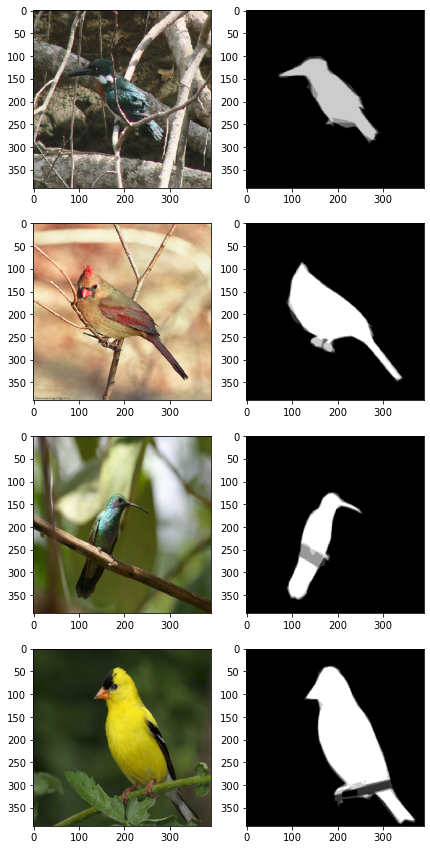

In [11]:
SEED = 43
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

n_pics_to_show = batch_size_train
inputs, masks = next(iter(dataloaders['val']))
fig, ax = plt.subplots(n_pics_to_show, 2, figsize=(7, 15))
for i in range(n_pics_to_show):
    pic, label = inputs[i], masks[i] 
    label_np = label.data.numpy().transpose(1, 2, 0) 
    pic_np = pic.data.numpy().transpose(1, 2, 0) 
    ax[i,0].imshow(pic_np)
    ax[i,1].imshow(label_np)

In [12]:
from pyefd import elliptic_fourier_descriptors
import io

In [13]:
jpg_masks_folder = train_masks_path
jpg_masks_names = train_masks

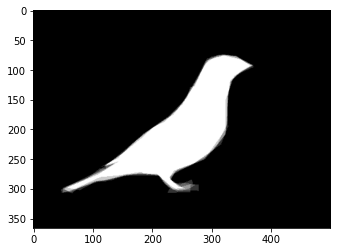

In [14]:
mask = cv2.imread(str(train_masks_path / train_masks[4]))
plt.imshow(mask)

In [29]:
path = jpg_masks_folder 
contours_dict_jpg = dict.fromkeys(jpg_masks_names)

for mask in contours_dict_jpg.keys():
    img = cv2.imread(str(path / mask))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(imgray, 127, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours_new = np.vstack(contours).squeeze()
    order = 10
    coeffs = elliptic_fourier_descriptors(contours_new, order=order)
    contours_dict_jpg[mask] = coeffs

In [35]:
sum_contours = 0
sum_index = 0
for i, cont in enumerate(list(contours_dict_jpg.values())):
    sum_contours += cont
    sum_index += i
    
coeffs_mean = sum_contours / sum_index

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from pyefd import elliptic_fourier_descriptors

def plot_efd(coeffs, order, locus=(0.0, 0.0), image=None, contour=None):
    """Plot a ``[2 x (N / 2)]`` grid of successive truncations of the series.

    .. note::

        Requires `matplotlib <http://matplotlib.org/>`_!

    :param numpy.ndarray coeffs: ``[N x 4]`` Fourier coefficient array.
    :param list, tuple or numpy.ndarray locus:
        The :math:`A_0` and :math:`C_0` elliptic locus in [#a]_ and [#b]_.
    :param int n: Number of points to use for plotting of Fourier series.

    """
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print("Cannot plot: matplotlib was not installed.")
        return

    N = coeffs.shape[0]
    N_half = int(np.ceil(N / 2))
    n_rows = 2
    n_cols = order//n_rows

    t = np.linspace(0, 1.0, order)
    xt = np.ones((order,)) * locus[0]
    yt = np.ones((order,)) * locus[1]
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(15,8))
    for n in range(coeffs.shape[0]):
        xt += (coeffs[n, 0] * np.cos(2 * (n + 1) * np.pi * t)) + (
            coeffs[n, 1] * np.sin(2 * (n + 1) * np.pi * t)
        )
        yt += (coeffs[n, 2] * np.cos(2 * (n + 1) * np.pi * t)) + (
            coeffs[n, 3] * np.sin(2 * (n + 1) * np.pi * t)
        )
        if n < n_cols:
            line = 0
            k = n
        else:
            line = 1
            k = n-n_cols
        ax[line, k].plot(yt, xt, 'black', linewidth=2)
        if image is not None:
            ax[line, k].imshow(image)

    plt.show()

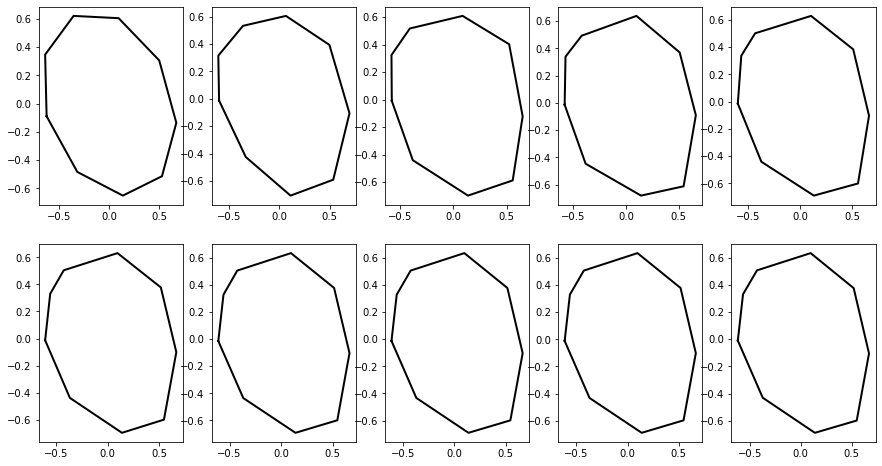

In [37]:
# coeffs_mean = contours_dict_jpg[train_masks[4]]
plot_efd(coeffs_mean, order=10)

In [38]:
locus = (0.0, 0.0)
m=10
xt = np.ones((m,)) * locus[0]
yt = np.ones((m,)) * locus[1]

t = np.linspace(0, 1.0, m)
    
for n in range(coeffs_mean.shape[0]):
    yt += (coeffs_mean[n, 0] * np.cos(2 * (n + 1) * np.pi * t)) + (
        coeffs_mean[n, 1] * np.sin(2 * (n + 1) * np.pi * t)
    )
    xt += (coeffs_mean[n, 2] * np.cos(2 * (n + 1) * np.pi * t)) + (
        coeffs_mean[n, 3] * np.sin(2 * (n + 1) * np.pi * t)
    )

(-0.6796498351334883,
 0.7319911779448387,
 -0.7555319910887783,
 0.7001338339156145)

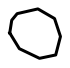

In [39]:
fig = plt.figure(figsize=(1, 1))
ax = fig.add_subplot(111)
ax.plot(xt, yt, 'black', linewidth=3)
ax.axis('off')

In [40]:
def get_img_from_fig(fig, dpi):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = np.rot90(img, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img

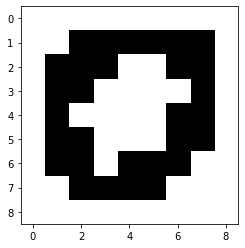

In [41]:
plot_img_np = get_img_from_fig(fig, dpi=9)

plt.imshow(plot_img_np)